# Figure 3 : Free atmosphere and near-surface warming as a function of elevation
Use the phd_v3 environment (can be replicated from the .yml file in envs/)

In [1]:
import xarray as xr
#import rioxarray as rxr
import xesmf as xe
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter
import string


from pyproj import CRS,Transformer,Proj

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
                 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
big_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
              'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50],'lonlim':[0.,20.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2,
                    'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}


### Defining the Alps

In [12]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False


#### Defining the elevation bands and pressure levels

In [13]:
# Levels (altitude bands)

levels = [np.logical_and(alps,H<400), np.logical_and(alps,np.logical_and(H>=400,H<600)), np.logical_and(alps,np.logical_and(H>=600,H<800)),
          np.logical_and(alps,np.logical_and(H>=800,H<1000)), np.logical_and(alps,np.logical_and(H>=1000,H<1200)), np.logical_and(alps,np.logical_and(H>=1200,H<1400)),
          np.logical_and(alps,np.logical_and(H>=1400,H<1600)), np.logical_and(alps,np.logical_and(H>=1600,H<1800)), np.logical_and(alps,np.logical_and(H>=1800,H<2000)),
          np.logical_and(alps,np.logical_and(H>=2000,H<2200)), np.logical_and(alps,np.logical_and(H>=2200,H<2400)), np.logical_and(alps,np.logical_and(H>=2400,H<2600)),
          np.logical_and(alps,np.logical_and(H>=2600,H<2800)), np.logical_and(alps,np.logical_and(H>=2800,H<3000)),
          np.logical_and(alps,H>=3000)]#,
          #alps]


H_levels = [300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900,3100]
H_levels_pressure = [760,1460,1950,3015,4210,5580,11785]
H_levels_pressure314 = [1460,3015,4210,5580,11785]

### Functions

In [14]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [15]:
def altitude_lev_slopes(dataset_slopes,levels,Height_levels=H_levels):
    ds_slopes_Hlev = dataset_slopes.where(levels[0]).mean(dim=('x','y'))
    ds_slopes_Hlev_std = dataset_slopes.where(levels[0]).std(dim=('x','y'))

    for lev in range(1,len(levels)):
        ds_slopes_Hlev = xr.concat([ds_slopes_Hlev,dataset_slopes.where(levels[lev]).mean(dim=('x','y'))], dim='Hlev')
        ds_slopes_Hlev_std = xr.concat([ds_slopes_Hlev_std,dataset_slopes.where(levels[lev]).std(dim=('x','y'))], dim='Hlev')

    ds_slopes_Hlev = ds_slopes_Hlev.assign_coords(Hlev=("Hlev", Height_levels))
    ds_slopes_Hlev_std = ds_slopes_Hlev_std.assign_coords(Hlev=("Hlev", Height_levels))

    return ds_slopes_Hlev, ds_slopes_Hlev_std

In [16]:
def make_ds_seas(path,simcode,vars,first_year,last_year):

    # creating seasonal dataarray with all vars
    Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
    t_timestep = 60*60*24 # 60*60*24 seconds in a day

    ds_yrs = xr.open_dataset(path+'.EU'+simcode+'.'+vars[0]+'.'+str(first_year)+'.nc')#.resample(time='D').mean()

    for var in vars[1:]:
        ds_var = xr.open_dataset(path+'.EU'+simcode+'.'+var+'.'+str(first_year)+'.nc')#.resample(time='D').mean()
        ds_yrs[var] = ds_var[var]


    ds_yrs = season_mean(ds_yrs).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

    for year in range(first_year+1,last_year+1):
        print(year,end=' ')
        ds_singleyr = xr.open_dataset(path+'.EU'+simcode+'.'+vars[0]+'.'+str(year)+'.nc')#.resample(time='D').mean()

        for var in vars[1:]:
            ds_var = xr.open_dataset(path+'.EU'+simcode+'.'+var+'.'+str(year)+'.nc')#.resample(time='D').mean()
            ds_singleyr[var] = ds_var[var]
    
        print('Computing season mean',end=' ')
        ds_singleyr = season_mean(ds_singleyr).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
        ds_yrs = xr.concat([ds_yrs,ds_singleyr], dim='Year')

    yrs = np.arange(first_year,last_year+1)
    ds_yrs = ds_yrs.assign_coords(Year=("Year", yrs))

    return ds_yrs
    

In [17]:
def making_slopes_gd_freeatm(ds_hist, ds_fut):
    msk_TTp = np.logical_and(ds_hist.TTp.mean(axis=0) < 1000, ds_fut.TTp.mean(axis=0) < 1000) # 1000:arbitrary value, we just want to filter 10**(34) values

    alps_TTp = np.logical_and(alps,msk_TTp)
    
    ds_slopes_hist = ds_hist.polyfit('Year', deg=1)
    ds_slopes_Hlev_hist, ds_slopes_Hlev_hist_std = altitude_lev_slopes(ds_slopes_hist.TTz_polyfit_coefficients,levels=levels)
    ds_slopes_Hlev_hist_TTp = ds_slopes_hist.sel(degree=1).TTp_polyfit_coefficients.where(alps_TTp).mean(dim=('x','y'))
    ds_slopes_Hlev_hist_std_TTp = ds_slopes_hist.sel(degree=1).TTp_polyfit_coefficients.where(alps_TTp).std(dim=('x','y'))

    ds_slopes_fut = ds_fut.polyfit('Year', deg=1)
    ds_slopes_Hlev_fut, ds_slopes_Hlev_fut_std = altitude_lev_slopes(ds_slopes_fut.TTz_polyfit_coefficients,levels=levels)
    ds_slopes_Hlev_fut_TTp = ds_slopes_fut.sel(degree=1).TTp_polyfit_coefficients.where(alps_TTp).mean(dim=('x','y'))
    ds_slopes_Hlev_fut_std_TTp = ds_slopes_fut.sel(degree=1).TTp_polyfit_coefficients.where(alps_TTp).std(dim=('x','y'))

    return ds_slopes_Hlev_hist, ds_slopes_Hlev_hist_std, ds_slopes_Hlev_hist_TTp, ds_slopes_Hlev_hist_std_TTp, ds_slopes_Hlev_fut, ds_slopes_Hlev_fut_std, \
            ds_slopes_Hlev_fut_TTp, ds_slopes_Hlev_fut_std_TTp


In [18]:
def plot_ground_freeatm(ds_in_hist1,ds_in_fut1,ds_in_hist2,ds_in_fut2,ds_in_hist3,ds_in_fut3,ds_in_hist4,ds_in_fut4,multiplier=10,label_on_left='',
                           H_levels_pressure=H_levels_pressure):
    # multiplier =10 if trends per decade
    pplt.rc.update(small=12, large=12)

    H_levels_pressure314 = [1460,3015,4210,5580,11785]
    seasons=['DJF','MAM','JJA','SON']
    # mask for under-the-surface values at 800hPa and other pressures

    ds1_slopes_Hlev_hist, ds1_slopes_Hlev_hist_std, ds1_slopes_Hlev_hist_TTp, ds1_slopes_Hlev_hist_std_TTp, ds1_slopes_Hlev_fut, ds1_slopes_Hlev_fut_std, \
    ds1_slopes_Hlev_fut_TTp, ds1_slopes_Hlev_fut_std_TTp = making_slopes_gd_freeatm(ds_in_hist1, ds_in_fut1)

    ds2_slopes_Hlev_hist, ds2_slopes_Hlev_hist_std, ds2_slopes_Hlev_hist_TTp, ds2_slopes_Hlev_hist_std_TTp, ds2_slopes_Hlev_fut, ds2_slopes_Hlev_fut_std, \
    ds2_slopes_Hlev_fut_TTp, ds2_slopes_Hlev_fut_std_TTp = making_slopes_gd_freeatm(ds_in_hist2, ds_in_fut2)

    ds3_slopes_Hlev_hist, ds3_slopes_Hlev_hist_std, ds3_slopes_Hlev_hist_TTp, ds3_slopes_Hlev_hist_std_TTp, ds3_slopes_Hlev_fut, ds3_slopes_Hlev_fut_std, \
    ds3_slopes_Hlev_fut_TTp, ds3_slopes_Hlev_fut_std_TTp = making_slopes_gd_freeatm(ds_in_hist3, ds_in_fut3)

    ds4_slopes_Hlev_hist, ds4_slopes_Hlev_hist_std, ds4_slopes_Hlev_hist_TTp, ds4_slopes_Hlev_hist_std_TTp, ds4_slopes_Hlev_fut, ds4_slopes_Hlev_fut_std, \
    ds4_slopes_Hlev_fut_TTp, ds4_slopes_Hlev_fut_std_TTp = making_slopes_gd_freeatm(ds_in_hist4, ds_in_fut4)
    
    list_slopes_Hlev_hist=[[ds1_slopes_Hlev_hist,ds2_slopes_Hlev_hist,ds3_slopes_Hlev_hist,ds4_slopes_Hlev_hist],
                           [ds1_slopes_Hlev_hist_std,ds2_slopes_Hlev_hist_std,ds3_slopes_Hlev_hist_std,ds4_slopes_Hlev_hist_std]]
    list_slopes_Hlev_hist_TTp=[[ds1_slopes_Hlev_hist_TTp,ds2_slopes_Hlev_hist_TTp,ds3_slopes_Hlev_hist_TTp,ds4_slopes_Hlev_hist_TTp],
                               [ds1_slopes_Hlev_hist_std_TTp,ds2_slopes_Hlev_hist_std_TTp,ds3_slopes_Hlev_hist_std_TTp,ds4_slopes_Hlev_hist_std_TTp]]
    list_slopes_Hlev_fut=[[ds1_slopes_Hlev_fut,ds2_slopes_Hlev_fut,ds3_slopes_Hlev_fut,ds4_slopes_Hlev_fut],
                          [ds1_slopes_Hlev_fut_std,ds2_slopes_Hlev_fut_std,ds3_slopes_Hlev_fut_std,ds4_slopes_Hlev_fut_std]]
    list_slopes_Hlev_fut_TTp=[[ds1_slopes_Hlev_fut_TTp,ds2_slopes_Hlev_fut_TTp,ds3_slopes_Hlev_fut_TTp,ds4_slopes_Hlev_fut_TTp],
                              [ds1_slopes_Hlev_fut_std_TTp,ds2_slopes_Hlev_fut_std_TTp,ds3_slopes_Hlev_fut_std_TTp,ds4_slopes_Hlev_fut_std_TTp]]
    
    f, axs = pplt.subplots(ncols=4,nrows=4,axheight=1.7,axwidth=3,right=6)

    for sim in range(len(list_slopes_Hlev_hist[0])):
        for seas in range(4):
            ax = axs[seas+4*sim]
            if len(list_slopes_Hlev_hist_TTp[0][sim].isel(season=seas)) == len(H_levels_pressure):
                #print(list_slopes_Hlev_hist_TTp[0][sim].isel(season=seas).shape)
                H_levels_pressure = H_levels_pressure
            else:
                #print('else')
                #print(list_slopes_Hlev_hist_TTp[0][sim].isel(season=seas).shape)
                H_levels_pressure = H_levels_pressure314
            for m in range(len(H_levels_pressure)):
                ax.plot([-0.15,1.9],[H_levels_pressure[m],H_levels_pressure[m]],linestyle='--',c='k',linewidth=0.75,alpha=0.3)

            ax.plot(multiplier*list_slopes_Hlev_hist[0][sim].isel(ztqlev=0,season=seas,degree=0),H_levels,c='sienna',linestyle='--')
            ax.plot(multiplier*list_slopes_Hlev_fut[0][sim].isel(ztqlev=0,season=seas,degree=0),H_levels,c='sienna')
        
            ax.plot(multiplier*list_slopes_Hlev_hist_TTp[0][sim].isel(season=seas),H_levels_pressure,c='deepskyblue',linestyle='--')
            ax.plot(multiplier*list_slopes_Hlev_fut_TTp[0][sim].isel(season=seas),H_levels_pressure,c='deepskyblue')
            for lev in range(len(levels)): # spatial standard deviation
                var='TTz'
                slope_var = list_slopes_Hlev_hist[0][sim].isel(ztqlev=0,season=seas,degree=0)[lev]
                std_var = list_slopes_Hlev_hist[1][sim].isel(ztqlev=0,season=seas,degree=0)[lev] # std
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c='sienna')

                slope_var = list_slopes_Hlev_fut[0][sim].isel(ztqlev=0,season=seas,degree=0)[lev]
                std_var = list_slopes_Hlev_fut[1][sim].isel(ztqlev=0,season=seas,degree=0)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c='sienna')

                if lev<len(H_levels_pressure):
                    var='TTp'
                    slope_var = list_slopes_Hlev_hist_TTp[0][sim].isel(season=seas)[lev]
                    std_var = list_slopes_Hlev_hist_TTp[1][sim].isel(season=seas)[lev]
                    ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels_pressure[lev],H_levels_pressure[lev]],c='deepskyblue',
                            linestyle='--')

                    slope_var = list_slopes_Hlev_fut_TTp[0][sim].isel(season=seas)[lev]
                    std_var = list_slopes_Hlev_fut_TTp[1][sim].isel(season=seas)[lev]
                    ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels_pressure[lev],H_levels_pressure[lev]],c='deepskyblue')

            ax.set_xlim(-0.15,1.0)
            ax.set_xticks(np.arange(0.,1.,0.25))
            ax.set_ylim(200,6000)

            if seas==3:
                if len(H_levels_pressure) == 7:
                    ax.text(1.01, 650, "925", fontsize=11)
                    ax.text(1.01, 1840, "800", fontsize=11)
                ax.text(1.01, 1340, "850", fontsize=11)
                ax.text(1.01, 2880, "700", fontsize=11)
                ax.text(1.01, 4100, "600", fontsize=11)
                ax.text(1.01, 5430, "500", fontsize=11)
                #ax.text(0.61, 11650, "200", fontsize=9)
                # if seas==2:
                #     ax.text(1.08,6000,'Pressure (hPa)',rotation='vertical',fontsize=12,wrap=False)

    #f.subplots_adjust(right=0.85)
    # Add manual subplot labels (a–h, for example)
    letters = list(string.ascii_lowercase)  # ['a','b','c',...]
    labels = letters[:len(axs)]  # e.g. ['a','b','c','d'] or ['e','f','g','h']

    # You can offset starting letter manually (e.g. start at 'e')
    start_index = 0  # 0-based, so 4 = 'e'
    labels = letters[start_index:start_index+len(axs)]

    for i, ax in enumerate(axs):
        ax.text(
            0.02, 0.95, f"({labels[i]})",
            transform=ax.transAxes,
            fontsize=13,
            fontweight='bold',
            va='top', ha='left'
        )
    f.text(0.975,0.45,'Pressure (hPa)',rotation='vertical',fontsize=12)
    axs.format(collabels=['DJF','MAM','JJA', 'SON'],xlabel='T trend (°C/decade)',ylabel='Elevation (m.a.s.l.)',rowlabels=label_on_left)

### Preparing the data

In [19]:
ds_ECEarth_hist_TTz_TTp = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST',simcode='e',vars=['TTz','TTp'],
                                       first_year=1961,last_year=2014)

1962 Computing season mean 1963 Computing season mean 1964 Computing season mean 1965 Computing season mean 1966 Computing season mean 1967 Computing season mean 1968 Computing season mean 1969 Computing season mean 1970 Computing season mean 1971 Computing season mean 1972 Computing season mean 1973 Computing season mean 1974 Computing season mean 1975 Computing season mean 1976 Computing season mean 1977 Computing season mean 1978 Computing season mean 1979 Computing season mean 1980 Computing season mean 1981 Computing season mean 1982 Computing season mean 1983 Computing season mean 1984 Computing season mean 1985 Computing season mean 1986 Computing season mean 1987 Computing season mean 1988 Computing season mean 1989 Computing season mean 1990 Computing season mean 1991 Computing season mean 1992 Computing season mean 1993 Computing season mean 1994 Computing season mean 1995 Computing season mean 1996 Computing season mean 1997 Computing season mean 1998 Computing season mean 1

In [92]:
yrs = np.arange(1961,2015)

ds_ECEarth_hist_TTz_TTp = ds_ECEarth_hist_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [93]:
ds_ECEarth_hist_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_ECEarth3/ds_TTz_TTp_1961_2014_seas.npy')

In [22]:
ds_ECEarth_SSP245_TTz_TTp = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245',simcode='e',vars=['TTz','TTp'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [90]:
yrs = np.arange(2015,2101)

ds_ECEarth_SSP245_TTz_TTp = ds_ECEarth_SSP245_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [91]:
ds_ECEarth_SSP245_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_ECEarth3/ds_TTz_TTp_2015_2100_seas.npy')

In [24]:
ds_MPI_hist_TTz_TTp = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST',simcode='y',vars=['TTz','TTp'],
                                       first_year=1961,last_year=2014)

1962 Computing season mean 1963 Computing season mean 1964 Computing season mean 1965 Computing season mean 1966 Computing season mean 1967 Computing season mean 1968 Computing season mean 1969 Computing season mean 1970 Computing season mean 1971 Computing season mean 1972 Computing season mean 1973 Computing season mean 1974 Computing season mean 1975 Computing season mean 1976 Computing season mean 1977 Computing season mean 1978 Computing season mean 1979 Computing season mean 1980 Computing season mean 1981 Computing season mean 1982 Computing season mean 1983 Computing season mean 1984 Computing season mean 1985 Computing season mean 1986 Computing season mean 1987 Computing season mean 1988 Computing season mean 1989 Computing season mean 1990 Computing season mean 1991 Computing season mean 1992 Computing season mean 1993 Computing season mean 1994 Computing season mean 1995 Computing season mean 1996 Computing season mean 1997 Computing season mean 1998 Computing season mean 1

In [88]:
yrs = np.arange(1961,2015)

ds_MPI_hist_TTz_TTp = ds_MPI_hist_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [89]:
ds_MPI_hist_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds_TTz_TTp_1961_2014_seas.npy')

In [26]:
ds_MPI_SSP245_TTz_TTp = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP245/daily/ICE.MPI-ESM_SSP245',simcode='v',vars=['TTz','TTp'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [86]:
yrs = np.arange(2015,2101)

ds_MPI_SSP245_TTz_TTp = ds_MPI_SSP245_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [87]:
ds_MPI_SSP245_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds_TTz_TTp_2015_2100_SSP245_seas.npy')

In [28]:
ds_MPI_SSP585_TTz_TTp = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP585/daily/ICE.MPI-ESM_SSP585',simcode='y',vars=['TTz','TTp'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [82]:
yrs = np.arange(2015,2101)

ds_MPI_SSP585_TTz_TTp = ds_MPI_SSP585_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [85]:
ds_MPI_SSP585_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds_TTz_TTp_2015_2100_SSP585_seas.npy')

#### v3.14

In [10]:
ds314_MPI_hist_TTz_TTp = make_ds_seas(path='/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain/HIST/ICE.MPI-ESM_HIST',simcode='n',vars=['TTz','TTp'],
                                       first_year=1961,last_year=2014)

1962 Computing season mean 1963 Computing season mean 1964 Computing season mean 1965 Computing season mean 1966 Computing season mean 1967 Computing season mean 1968 Computing season mean 1969 Computing season mean 1970 Computing season mean 1971 Computing season mean 1972 Computing season mean 1973 Computing season mean 1974 Computing season mean 1975 Computing season mean 1976 Computing season mean 1977 Computing season mean 1978 Computing season mean 1979 Computing season mean 1980 Computing season mean 1981 Computing season mean 1982 Computing season mean 1983 Computing season mean 1984 Computing season mean 1985 Computing season mean 1986 Computing season mean 1987 Computing season mean 1988 Computing season mean 1989 Computing season mean 1990 Computing season mean 1991 Computing season mean 1992 Computing season mean 1993 Computing season mean 1994 Computing season mean 1995 Computing season mean 1996 Computing season mean 1997 Computing season mean 1998 Computing season mean 1

In [11]:
yrs = np.arange(1961,2015)

ds314_MPI_hist_TTz_TTp = ds314_MPI_hist_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [12]:
ds314_MPI_hist_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds314_TTz_TTp_1961_2014_seas.npy')

In [13]:
ds314_MPI_SSP585_TTz_TTp = make_ds_seas(path='/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain/SSP585/ICE.MPI-ESM_SSP585',simcode='n',vars=['TTz','TTp'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [14]:
yrs = np.arange(2015,2101)

ds314_MPI_SSP585_TTz_TTp = ds314_MPI_SSP585_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [15]:
ds314_MPI_SSP585_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds314_TTz_TTp_2015_2100_SSP585_seas.npy')

### Making the plot

#### Loading the data prepared above

In [6]:
ds_ECEarth_hist_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_ECEarth3/ds_TTz_TTp_1961_2014_seas.npy').isel(y=slice(jmin,jmax),x=slice(imin,imax))
ds_ECEarth_SSP245_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_ECEarth3/ds_TTz_TTp_2015_2100_seas.npy').isel(y=slice(jmin,jmax),x=slice(imin,imax))

In [7]:
ds_MPI_hist_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds_TTz_TTp_1961_2014_seas.npy').isel(y=slice(jmin,jmax),x=slice(imin,imax))
ds_MPI_SSP245_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds_TTz_TTp_2015_2100_SSP245_seas.npy').isel(y=slice(jmin,jmax),
                                                                                                                                        x=slice(imin,imax))
ds_MPI_SSP585_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds_TTz_TTp_2015_2100_SSP585_seas.npy').isel(y=slice(jmin,jmax),
                                                                                                                                        x=slice(imin,imax))

In [8]:
ds314_MPI_hist_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds314_TTz_TTp_1961_2014_seas.npy').isel(y=slice(jmin,jmax),
                                                                                                                                     x=slice(imin,imax))
ds314_MPI_SSP585_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds314_TTz_TTp_2015_2100_SSP585_seas.npy').isel(y=slice(jmin,jmax),
                                                                                                                                              x=slice(imin,imax))

#### Plot

/tmp/ipykernel_430360/59443171.py:4: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=12)
/tmp/ipykernel_430360/59443171.py:4: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=12)


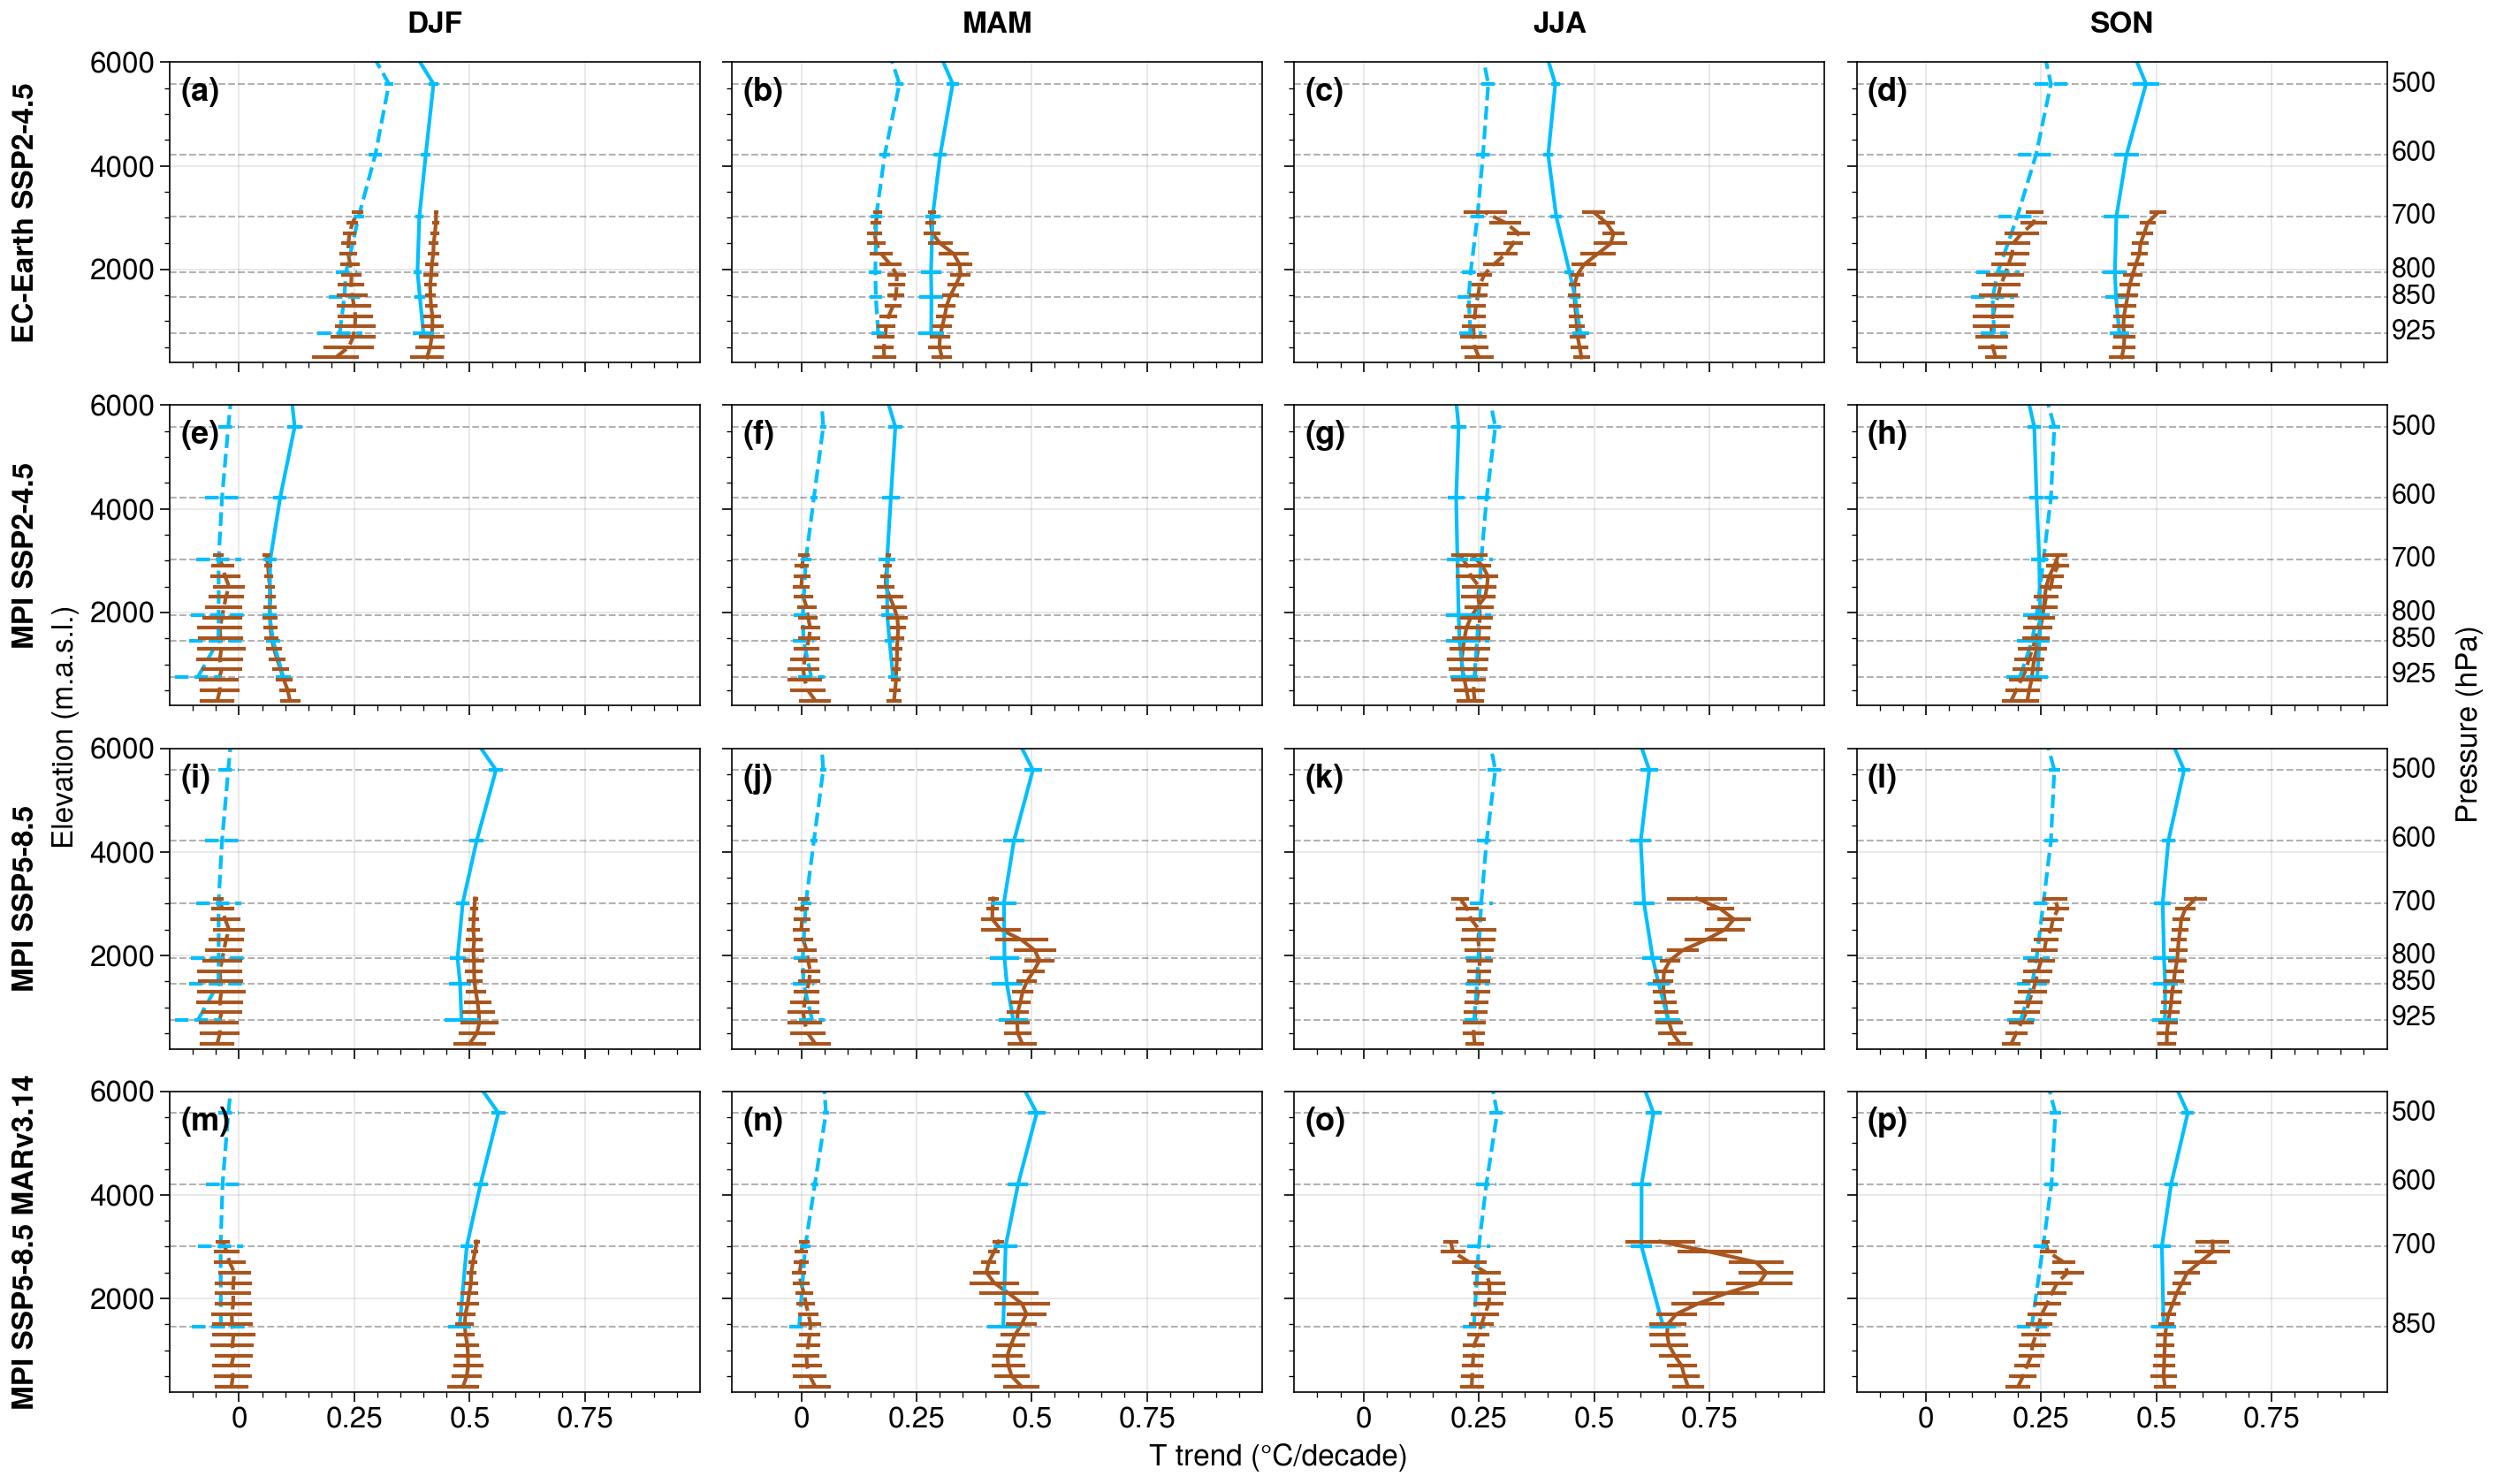

In [19]:
pplt.rc['figure.facecolor'] = 'white'

plot_ground_freeatm(ds_in_hist1 = ds_ECEarth_hist_TTz_TTp, ds_in_fut1 = ds_ECEarth_SSP245_TTz_TTp,
                    ds_in_hist2 = ds_MPI_hist_TTz_TTp, ds_in_fut2 = ds_MPI_SSP245_TTz_TTp,
                    ds_in_hist3 = ds_MPI_hist_TTz_TTp, ds_in_fut3 = ds_MPI_SSP585_TTz_TTp,
                    ds_in_hist4 = ds314_MPI_hist_TTz_TTp, ds_in_fut4 = ds314_MPI_SSP585_TTz_TTp,
                    label_on_left=["EC-Earth SSP2-4.5","MPI SSP2-4.5","MPI SSP5-8.5","MPI SSP5-8.5 MARv3.14"])